In [1]:
#import necessary library
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
test_DF = pd.read_csv("/home/jupyter/test_DF.csv", sep = "\t", encoding= "utf-8")
test_DF.head()

,pid,track_id,label
0,102312,310283,1
1,14157,26349,1
2,113235,312440,1
3,129834,20220,1
4,124700,16483,1


In [3]:
def makeDF(testDF, predictionsDF): #wrap everything into a pandas dataframe. easier to analyse
    pred_df = pd.DataFrame({
    'user_id': np.array(testDF['pid']),
    'item_id': np.array(testDF["track_id"]),
    'prediction': predictionsDF.flatten()
    })
    return pred_df

topk_HR is a function to compute the hit rate for the top k items recommended by our model. NCF model output is an array of probability, hence we have to define a threshold which is a hyperparameter to convert the probability output to be binary. Then, since the test set is made of all user item pairs that have labels as 1 so we just compute the number of classified 1 over the total number of tracks correspoded to the pid. We then take the mean of HR of all pid. 

In [4]:
def topk_HR(predicted_DF, K, thresholds):
    sorted_predictions = predicted_DF.groupby('user_id').apply(lambda x: x.sort_values(by='prediction', ascending=False)).reset_index(drop=True)
    topk_recommendations = sorted_predictions.groupby('user_id').head(K) #top k recommendations for each user
    toFilter = topk_recommendations.copy() #make a copy of the dataframe in case we accidentally mutate the origanal dataframe
    toFilter.loc[:, 'label'] = (toFilter['prediction'] > thresholds).astype(int) #if the prediction is greater than the threshold, label it as 1, else 0
    hit_count = toFilter.groupby('user_id')['label'].agg([('hit_rate', lambda x: sum(x == 1))]).reset_index() #count the number of 1s for each user
    hit_count['HR'] = hit_count['hit_rate'].apply(lambda x: x/K) #calculate the hit rate
    HRvalue = hit_count['HR'].mean() #`calculate the average hit rate across all users 
    return HRvalue

$DCG = \sum_{i=1}^k{\frac{rel_i}{log_2(i+1)}}$   
IDCG is the maximum possible DCG value, which is obtained by sorting the $rel_i$ and then calculating the DCG.   
NDCG = DCG/IDCG

In [5]:
def dcg_at_k(r, k):
    r = np.asarray(r)[:k]
    return np.sum(r / np.log2(np.arange(2, len(r) + 2))) #follow the formula above

def ndcg_at_k(r, k):
    dcg_max = dcg_at_k(sorted(r, reverse=True), k) #sort the relevance score in descending order and calculate the dcg_max
    if not dcg_max: #if dcg_max is 0, return 0 to prevent dividing by 0
        return 0.0
    return dcg_at_k(r, k) / dcg_max #calculate the ndcg

def average_ndcg(predicted_df, k, threshold):
    ndcg_values = []
    for user_id in predicted_df['user_id'].unique(): #for each user, calculate the ndcg 
        user_data = predicted_df[predicted_df['user_id'] == user_id] #get the data for that user
        relevance = (user_data['prediction'] > threshold).astype(int).tolist() #get the relevance score for that user
        ndcg_values.append(ndcg_at_k(relevance, k)) #calculate the ndcg for that user and append it to the list
    avg_ndcg = np.mean(ndcg_values) #calculate the average ndcg across all users
    return avg_ndcg

In [6]:
latent_prediction = []
list_direc = os.listdir("/home/jupyter/model_results/") #we had save the reults into file system hence exact path required
for direct in list_direc:
    if direct.startswith('latent') and direct.endswith('npy'): #npy file stores prediction array. 
        path = '/home/jupyter/model_results/' + direct
        basename, _ = direct.split(".")
        fread = np.load(path) #laod data
        latent_prediction.append({str(basename): fread})

In [7]:
prediction_df_dict = {} #create a dictionary to store the prediction dataframe
for dict_ in latent_prediction:
    for key, value in dict_.items():
        df = makeDF(testDF = test_DF, predictionsDF = value)   #make a dataframe for each prediction
        prediction_df_dict[key] = df

In [9]:
prediction_df_dict 

{'latent_64':         user_id  item_id  prediction
 0        102312   310283    0.674561
 1         14157    26349    0.996863
 2        113235   312440    0.983125
 3        129834    20220    0.016977
 4        124700    16483    0.959838
 ...         ...      ...         ...
 324559      811   376698    0.000121
 324560   127557   375764    0.480609
 324561   127461   376554    0.997244
 324562   125860    42605    0.931885
 324563   105350    76964    0.990336
 
 [324564 rows x 3 columns],
 'latent_8':         user_id  item_id  prediction
 0        102312   310283    0.933719
 1         14157    26349    0.981995
 2        113235   312440    0.594253
 3        129834    20220    0.308550
 4        124700    16483    0.960283
 ...         ...      ...         ...
 324559      811   376698    0.000013
 324560   127557   375764    0.995463
 324561   127461   376554    0.958120
 324562   125860    42605    0.723493
 324563   105350    76964    0.991421
 
 [324564 rows x 3 columns],
 'l

In [10]:
k_values = np.arange(10, 100, 5) 
threshold_values = np.arange(0.5, 0.95, 0.05)
kList, thresholdList = np.meshgrid(k_values, threshold_values)
HRL = np.empty_like(kList, dtype=float)

for i, k in enumerate(tqdm(k_values)):
    for j, threshold in enumerate(threshold_values):
        HRL[j, i] = topk_HR(prediction_df_dict['latent_64'], k, threshold) #calculate the hit rate for each combination of k and threshold


100%|██████████| 18/18 [06:17<00:00, 20.97s/it]


## Plot hit rate against threshold and k. 

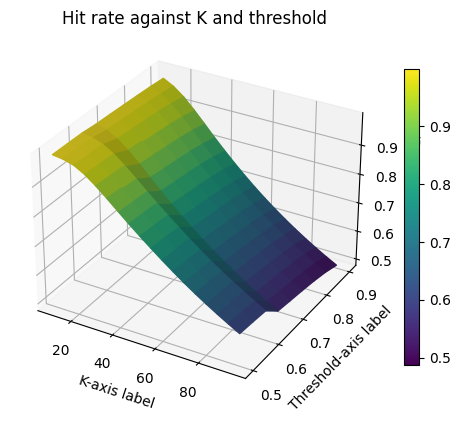

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
norm = plt.Normalize(HRL.min(), HRL.max())
colors = plt.cm.viridis(norm(HRL))

surf = ax.plot_surface(kList, thresholdList, HRL, facecolors=colors, shade=True)
m = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
m.set_array(HRL)
fig.colorbar(m, shrink=0.8)

ax.set_xlabel('K-axis label')
ax.set_ylabel('Threshold-axis label')
ax.set_zlabel('HRL-axis label')
ax.set_title('Hit rate against K and threshold')

plt.show()

all the numerical results are stored in another csv file for better presentation. 

In [12]:
MLP_prediction = []
list_direc = os.listdir("/home/jupyter/model_results/")
for direct in list_direc:
    if direct.startswith('MLP') and direct.endswith('npy'):
        path = '/home/jupyter/model_results/' + direct
        basename, _ = direct.split(".")
        fread = np.load(path)
        MLP_prediction.append({str(basename): fread})

In [13]:
prediction_df_dict_MLP = {}
for dict_ in MLP_prediction:
    for key, value in dict_.items():
        df = makeDF(testDF = test_DF, predictionsDF = value)
        prediction_df_dict_MLP[key] = df

In [14]:
prediction_df_dict_MLP

{'MLP_6':         user_id  item_id  prediction
 0        102312   310283    0.524261
 1         14157    26349    0.006759
 2        113235   312440    0.999730
 3        129834    20220    0.721051
 4        124700    16483    0.999730
 ...         ...      ...         ...
 324559      811   376698    0.000225
 324560   127557   375764    0.998943
 324561   127461   376554    0.998566
 324562   125860    42605    1.000000
 324563   105350    76964    0.999958
 
 [324564 rows x 3 columns],
 'MLP_1':         user_id  item_id  prediction
 0        102312   310283    0.943712
 1         14157    26349    0.995195
 2        113235   312440    0.529701
 3        129834    20220    0.009557
 4        124700    16483    0.988418
 ...         ...      ...         ...
 324559      811   376698    0.000047
 324560   127557   375764    0.170549
 324561   127461   376554    0.965420
 324562   125860    42605    0.530712
 324563   105350    76964    0.997718
 
 [324564 rows x 3 columns],
 'MLP_5': 

In [15]:
items = [item for item in prediction_df_dict.items()]
HRresultsList = []
K = [100, 50, 30]
for k in tqdm(K):
    HRresults = {}
    for tuple_ in items:
        name, df = tuple_
        HRresults[name] = topk_HR(df, k, 0.85)
    HRresultsList.append(HRresults)

100%|██████████| 3/3 [00:34<00:00, 11.41s/it]


In [17]:
HRresultsList

[{'latent_64': 0.4839627208908255,
  'latent_8': 0.46499636891793755,
  'latent_32': 0.48307673686758656,
  'latent_128': 0.4781384652626483,
  'latent_16': 0.46528201404018393},
 {'latent_64': 0.7305833938513677,
  'latent_8': 0.7093536673928831,
  'latent_32': 0.731358024691358,
  'latent_128': 0.7251997095134349,
  'latent_16': 0.7102783829581215},
 {'latent_64': 0.8724683288953442,
  'latent_8': 0.8519406116356008,
  'latent_32': 0.8737271040103285,
  'latent_128': 0.8672476397966595,
  'latent_16': 0.8525942064068426}]

In [18]:
NDCGresultsList = []

K = [100, 50, 30]
for k in K:
    NDCGresults = {}
    for tuple_ in items:
        name, df = tuple_
        NDCGresults[name] = average_ndcg(df, k, 0.9)
    NDCGresultsList.append(NDCGresults)

In [19]:
NDCGresultsList

[{'latent_64': 0.8158600058309982,
  'latent_8': 0.7935190201682871,
  'latent_32': 0.8169369465667539,
  'latent_128': 0.8094513682786527,
  'latent_16': 0.7953230155711449},
 {'latent_64': 0.7523914473969932,
  'latent_8': 0.7262132845181416,
  'latent_32': 0.75235888614983,
  'latent_128': 0.7439513414115477,
  'latent_16': 0.7282019633828979},
 {'latent_64': 0.7031542318558774,
  'latent_8': 0.6737674583358431,
  'latent_32': 0.7028313136656246,
  'latent_128': 0.6937876527581182,
  'latent_16': 0.6766183422218103}]